# Autoencoder example

An autoencoder is a type of neural network structure that aims to learn efficiently compressed representations of input dataset. It achieves this by having a network architecture that tapers to some smaller latent space representation, before expanding back to the input size. An autoencoder can generally be thought of as consisting of two networks: the encoder and decoder networks respectively. The encoder is responsible for learning the compressed representation of the input data while the decoder is responsible for reconstructing the input from the latent variable representation.

Autoencoders are useful for a number of tasks such as denoising, feature extraction, data compression and anomaly detection. In this example, we will construct an autoencoder to perform denoising on a sliding window of temporal data.

In [1]:
# Uncomment this to automatically install the moku library in Google Colab or Jupyter Notebook
#%pip install -q moku[neuralnetwork]

# import the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

# set the seed for repeatability
np.random.seed(0)

2024-10-31 14:02:51.344693: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 14:02:51.345489: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 14:02:51.347056: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 14:02:51.352066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 14:02:51.362040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

# Data Generation

As an example use case, we will target a denoising application of an input signal. A useful aspect of autoencoders for this application is that we don't need to know the underlying properties of the noise-less input signal to train our autoencoder. 

We will assume our input signal has some additive white noise we wish to remove from it. We will use a series of random walks as our training data set for this autoencoder. A random walk can be thought of as a summation or integral over a time period of white noise. Training an autoencoder using these random walks allows it to encode these signals in a lower dimension latent space, and then extract useful information from this latent space on real input signals after training. 

In [2]:
# time base, width chosen to be 32
T = np.linspace(-1, 1, 32)

We define a random walk with a given step size on a given time base. To achieve this, we generate a random floating point number uniformly distributed between -1 and 1 as our starting point, and then repeatedly add another random floating point number drawn from a Gaussian distribution with zero mean, and standard deviation given by the step size. After each step is taken, we also clip the output to be between -1 and 1, as this is the allowed range of inputs for our network. 

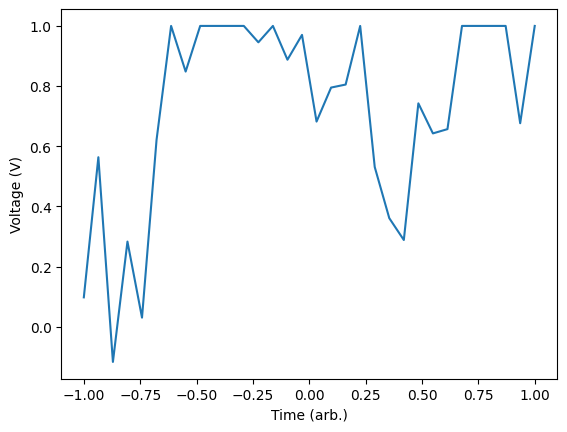

In [3]:
# random walk for training data
def random_walk(step_size, input_array):
    running_value = np.random.uniform(-1,1,1)[0]
    output_array = np.random.normal(0, step_size, input_array.shape)
    output_array[0] = running_value
    for idx, _ in enumerate(output_array):
        if idx != 0:
            output_array[idx] = np.clip(output_array[idx] + output_array[idx - 1], -1, 1)

    return output_array

# generate an example plot
rd_nn = random_walk(0.3, T)
plt.plot(T, rd_nn)
plt.xlabel('Time (arb.)')
plt.ylabel('Voltage (V)')
plt.show()

This produces a random walk with step size following a Gaussian distribution. To prepare our training data set, we take a large number of these walks, setting the standard deviation of the step size equal to 0.1. 

In [4]:
# define the length of our training data
data_len = 1000

# pre-define the arrays
training_data = np.zeros((data_len, T.size))

# generate a all of the random waveforms for training and store them
for idx in tqdm(range(data_len)):

    # get the random walks
    Y_train = random_walk(0.1, T)

    training_data[idx, :] = Y_train

100%|██████████| 1000/1000 [00:00<00:00, 13609.92it/s]


# Model definition and training

Now that we have created a training set we will create a model that can be transferred to the Moku after training. Using the provided package we will create an instance of the quantised model. This custom model class will take care of all our quantisation and data scaling.

In [5]:
# create the model object representing the quantized neural network in the Moku
quant_mod = LinnModel()

Since we have constructed our training data, we can tell the model what to use for training. This will automatically set up the scaling such that the inputs and outputs are mapped to the domain `[-1, 1]` which will facilitate later quantisation.

In [6]:
quant_mod.set_training_data(training_inputs=training_data, training_outputs=training_data)

We now need to define our model structure. To define a structure we will pass a list which contains the model definition. The definition is expected to be a list of tuples of either `(layer_size)` or `(layer_size, layer_activation)`. In our case we are going to define a 4 layer autoencoder which constricts to a latent space size of `2` with the intermediate layers each having a `tanh` activation function. The `show_summary` flag will output the model structure constructed in Tensorflow. There will be a number of intermediate layers for clipping the outputs to conform with the Moku FPGA requirements, but these can largely be ignored. 

In [7]:
# model definition for an autoencoder
model_definition = [(16, 'tanh'), (2, 'tanh'), (16, 'tanh'), (T.size, 'linear')]

# build the model
quant_mod.construct_model(model_definition, show_summary=True)

2024-10-31 14:03:03.565017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-31 14:03:03.565420: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer               │ (None, 16)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_1             │ (None, 2)              │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_2             │ (None, 16)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_3             │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,154 (4.51 KB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 0 (0.00 B)

We are now ready to train the model! This can be achieved by simply calling the `fit_model()` function and defining a number of training epochs. For this example we will also specify two additional parameters. The first is `validation_split` which corresponds to the percentage of training data that will be removed from the training process and instead used to validate the performance of the model. Using the validation data we will also define an early stopping configuration with the keyword `es_config`. In this configuration we will define 2 parameters: patience which defines how many epochs we go without seeing model improvement, and, restore which reverts the model to its most performant point.

In [8]:
# define the configuration for the early stopping
early_stopping_config = {'patience': 50, 'restore':True}

# set the training data
history = quant_mod.fit_model(epochs=1000, es_config=early_stopping_config, validation_split=0.1)

Value for monitor missing. Using default:val_loss.


Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3181 - val_loss: 0.2305
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.2113 - val_loss: 0.1483
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.1442 - val_loss: 0.0947
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.0901 - val_loss: 0.0659
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.0635 - val_loss: 0.0507
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.0504 - val_loss: 0.0427
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0425 - val_loss: 0.0361
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 0.0359 - val_loss: 0.0317
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 0.0315 - val_loss: 0.0290
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.0295 - val_loss: 0.0269
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0272 - val_loss: 0.0255
Epoch 12/1000
29/29 ━━━━━━━━━━━━

The history object that is returned contains a history of the training and validation losses. We can plot this to view how the model trained over the epochs. In the case the validation loss starts to increase our early stopping will kick in and halt the model training.

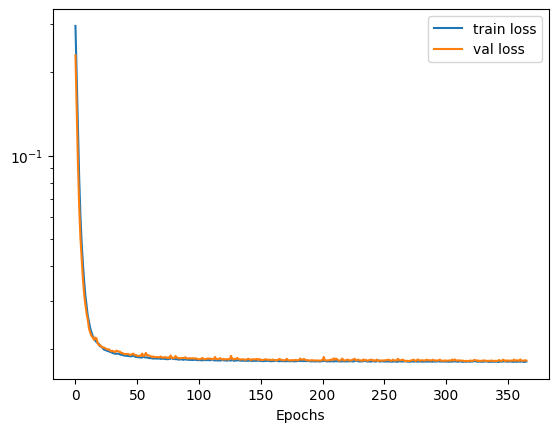

In [9]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

# Assess the model performance

Now the model has finished training we can view its performance by viewing some specific examples. We will create a sinusoidal signal and add some Gaussian noise to it

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


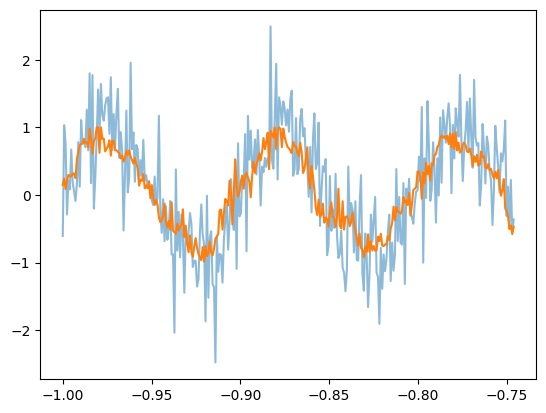

In [10]:
# noisy sin
total = 10
batch_size = T.size
T_extend = np.linspace(-1, 1, 2514)

complete_sin = np.sin(T_extend * np.pi * 20)
noise_sin = complete_sin + np.random.normal(0, 0.5, T_extend.size)
plt.plot(T_extend[:total*batch_size], noise_sin[:total*batch_size], alpha=0.5)

noisy_sin_batch = np.zeros((total*batch_size, batch_size))
for idx in range(total*batch_size):
    noisy_sin_batch[idx] = noise_sin[idx:(idx+batch_size)]

preds = np.zeros((total*batch_size, batch_size))
for i in range(total*batch_size):
    preds[i] = quant_mod.predict(noisy_sin_batch[i].reshape(1, -1), scale=False, unscale_output=False)

plt.plot(T_extend[:total*batch_size], preds[:, 0])
plt.show()

We can also compare this to a traditional Gaussian smoothing filter to compare the performance of the autoencoder. To achieve this, we convolve the signal with a Gaussian with the appropriate standard deviation with our noisy signal. This is equivalent to passing the signal through a low pass filter. 

As seen in the graphs below, the autoencoder performs comparably to the Gaussian smoothing, showing the effectiveness of the technique. 

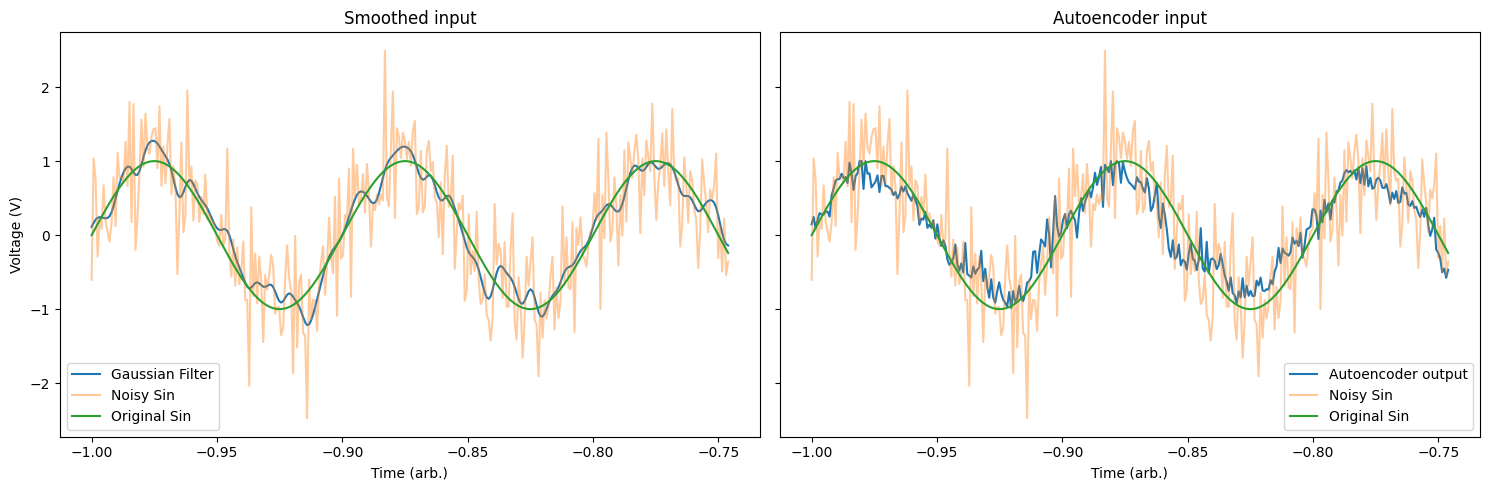

In [11]:
# smooth the input using a Gaussian filter
filter = np.exp(-np.linspace(-1, 1, total*batch_size)**2 / 5e-4)
filter /= np.sum(filter)
conv = np.convolve(filter, noise_sin[:total*batch_size], mode='same')

fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True)
# plot the smoothed solution
ax[0].plot(T_extend[:total*batch_size], conv[:total*batch_size], label='Gaussian Filter')
ax[0].plot(T_extend[:total*batch_size], noise_sin[:total*batch_size], alpha=0.4, label='Noisy Sin')
ax[0].plot(T_extend[:total*batch_size], complete_sin[:total*batch_size], label='Original Sin')
ax[0].set_title('Smoothed input')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_xlabel('Time (arb.)')
ax[0].legend()

# plot the autoencoder solution
ax[1].plot(T_extend[:total*batch_size], preds[:, 0], label='Autoencoder output')
ax[1].plot(T_extend[:total*batch_size], noise_sin[:total*batch_size], alpha=0.4, label='Noisy Sin')
ax[1].plot(T_extend[:total*batch_size], complete_sin[:total*batch_size], label='Original Sin')
ax[1].set_title('Autoencoder input')
ax[1].set_xlabel('Time (arb.)')
ax[1].legend()

plt.tight_layout()
plt.show()

# Deploying the Network onto a Moku:Pro

Now that the network has been trained, we can deploy it onto a Moku:Pro device. By saving the network with 1 input channel and 1 output channel, the network can be configured to take in 32 downsampled points of an input channel, and produce 32 points sequentially through its single output channel. We do this using the `save_linn` function:

In [12]:
save_linn(quant_mod, input_channels=1, output_channels=1, file_name='autoencoder.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 78 cycles


The sliding window nature of the serial network inputs and outputs means each consecutive batch of 32 outputs the network produces will overlap with 31 pf the previous outputs. To avoid overlapping the same output samples, we want the instrument to only output the most recent data point, which is the value of the last neuron in the last layer. To achieve this, we will use the optional `output_mapping` keyword argument to the `save_linn` function that lets us choose which output neurons are present in the final layer. We will set the `output_mapping` to only contain the final neuron in the last layer. 

In [13]:
save_linn(quant_mod, input_channels=1, output_channels=1, file_name='autoencoder.linn', output_mapping=[T.size-1])

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 78 cycles


With this adjusted model, we can now de-noise some signals on a moku device. This shows an example simulation of producing, de-noising and viewing a periodic signal using a Moku:Pro in multi-instrument mode. 

![](./Autoencoder_Screenshots/MIM_Setup.png "Multi Instrument Mode Setup")

Using multi-instrument mode, we can simulate a real-world signal with variable amounts of noise. We start by configuring a waveform generator to produce a periodic signal and some Gaussian noise. 

![](./Autoencoder_Screenshots/Waveform_Generator_Sine.png "Waveform Generator Producing a Sine Wave and Gaussian Noise")

We can use the control matrix in the PID isntrument to linearly combine the noise and signal, allowing us to significantly increase the amplitude of the noise relative to the underlying signal. Only `Out A` of the PID is used in this example. The red trace shows the incoming noiseless sine wave, and the blue trace shows the signal after noise was added to it. 

![](./Autoencoder_Screenshots/PID_Setup.png "PID Controller Adding a Linear Combination of Two Inputs")

We connect this noisy periodic signal to the input of the neural network instrument, with the adjusted model loaded as our network configuration. 

![](./Autoencoder_Screenshots/Neural_Network_Setup.png "Neural Network Loaded with Autoencoder Configuration")

Finally, we can view the original waveform, noise, noisy waveform, and output of the network using an oscilloscope instrument. The resulting network output works reasonably effectively as a denoised version of the original signal. These four signals are shown in order as the red (original waveform), blue (gaussian noise), green (noisy waveform) and yellow (de-noised signal) traces below. 

![](./Autoencoder_Screenshots/Sine_Results.png "Autoencoder De-Noising Sinusoidal Signal")

This works on a variety of periodic waveforms, including sine waves, triangle waves, and a cardiac waveform as a few examples. The same experiment repeated with triangle and cardiac waveforms is shown below, just requiring a reconfiguration of the waveform generator instrument to produce the desired noiselss signal. 

![](./Autoencoder_Screenshots/Triangle_Results.png "Autoencoder De-Noising Triangular Signal")

![](./Autoencoder_Screenshots/Cardiac_Results.png "Autoencoder De-Noising Cardiac Signal")